In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns

print(sys.path)
import pytropd.functions as tropdf
from own_functions import (vertical_weights, weights, calc_jet_lats, max_latitude, 
    get_ty_from, get_setup_from, calculate_max_lat, calc_theta, get_l0_from)
from visualization import (plot_zm_climatologies, plot_transports_intercomp, plot_hor_fields,
    plot_ep_flux_div, plot_EKE_spectral, plot_spectral_vd, plot_hayashi_spectra, 
    plot_wave_persistency)
from own_functions import r_air, kappa, kappai, g0, p00, r_e

pplt.rc.update({
    'figure.dpi': 100,
    'figure.figsize': (8,6),
    'savefig.dpi': 150,
})

['/home/b/b381739/masterarbeit', '/home/b/b381739/masterarbeit', '/home/b/b381739/code', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python39.zip', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/lib-dynload', '', '/home/b/b381739/.local/lib/python3.9/site-packages', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages']


## Setup

<xarray.Dataset>
Dimensions:   (time: 366, lat: 64, exp_name: 4)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * lat       (lat) float32 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
    plev      int64 700
  * exp_name  (exp_name) <U14 'EMIL_SW06_rfsc' ... 'EMIL_HS_cnvtst'
Data variables:
    vT_mt     (exp_name, time, lat) float64 0.8609 1.551 ... -0.1412 0.01732
    vT_et     (exp_name, time, lat) float64 -0.0313 -0.2996 ... -0.2358 -0.02945
    vu_mt     (exp_name, time, lat) float32 7.325 8.283 -37.24 ... 3.037 -2.252
    vu_et     (exp_name, time, lat) float32 -7.383 -112.1 -292.4 ... 210.1 29.91
    wu_mt     (exp_name, time, lat) float32 0.2982 -10.02 ... -3.423 0.2192
    wu_et     (exp_name, time, lat) float32 -0.8823 -3.713 ... 0.5433 -0.1527
    vdse_mt   (exp_name, time, lat) float32 1.067e+13 4.435e+13 ... -8.821e+12
    vdse_et   (exp_name, time, lat) float32 -6.505e+12 -7.027e+13 ... -5.689e+12

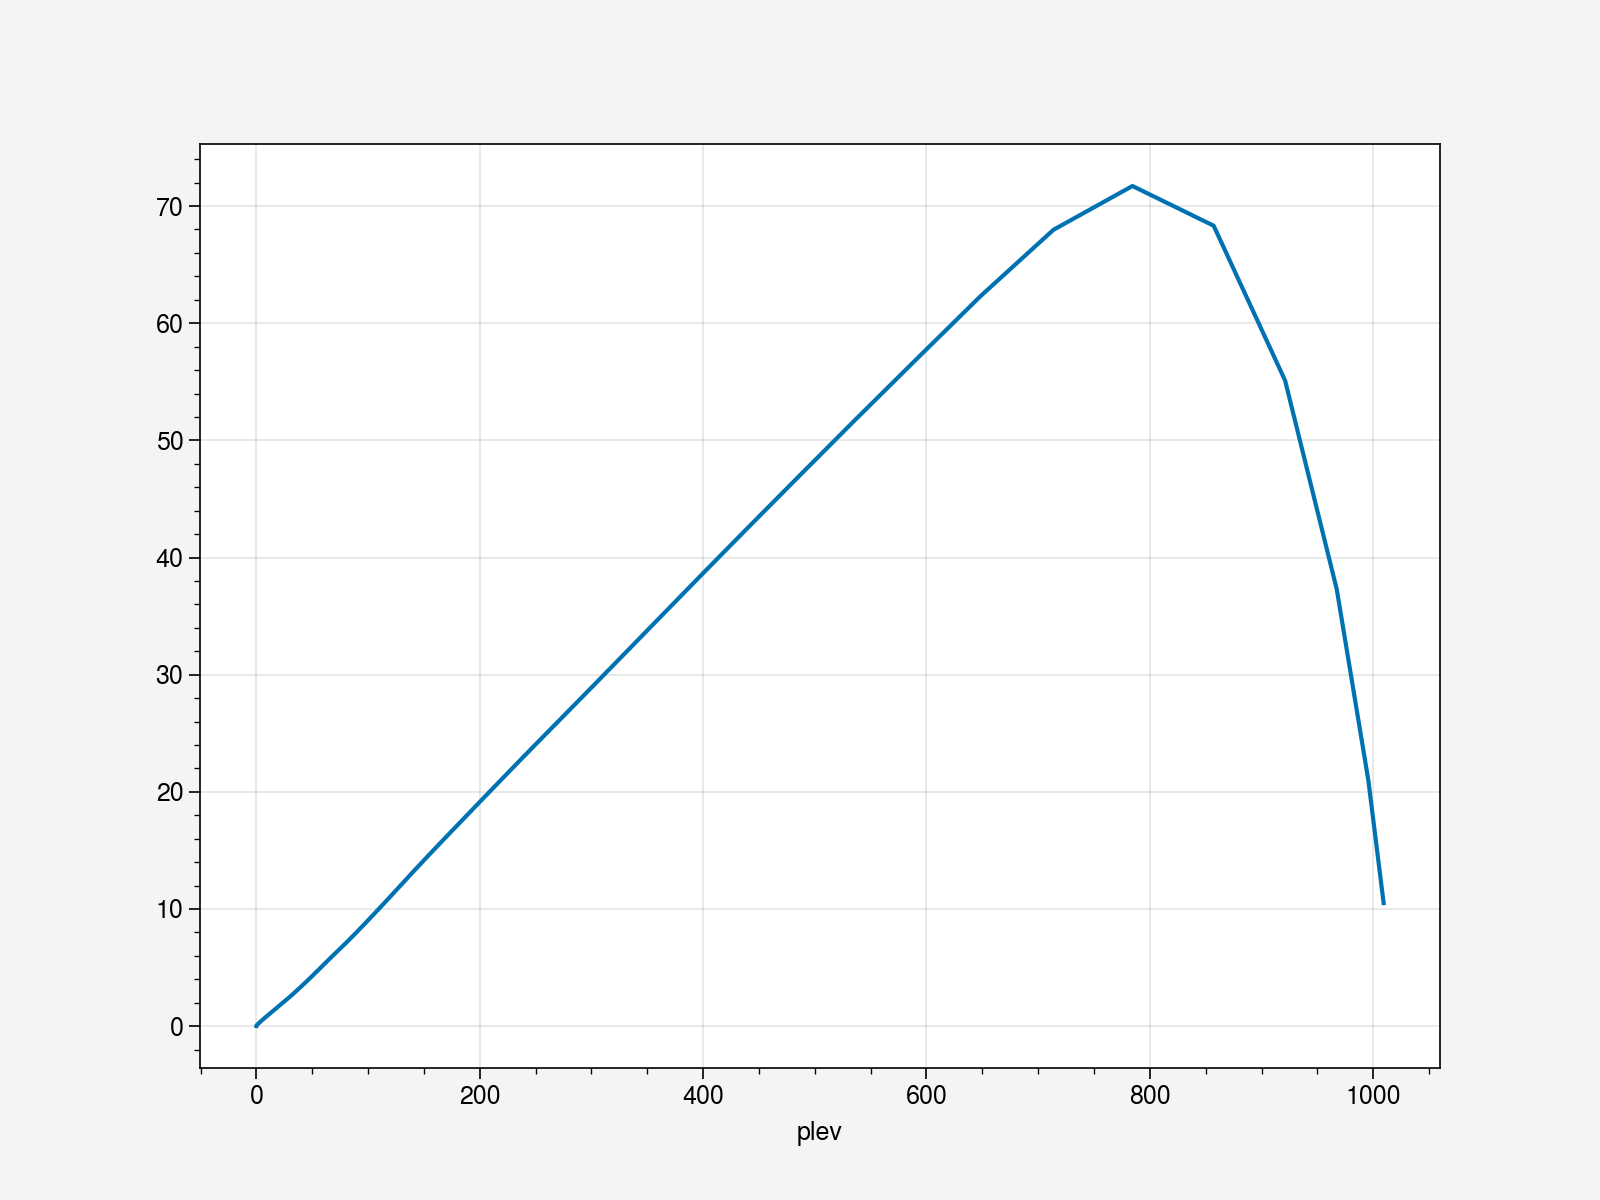

In [2]:
#exp_names = ['EMIL_HSl6_dy20', 'EMIL_HSl6_dy40', 'EMIL_HSl6_dy60', 'EMIL_HSl6_dy80', 'EMIL_HSl6_dy_C']
#exp_names = ['EMIL_SW06_dy80', 'EMIL_SW06_dy60', 'EMIL_SW06_rfsc']
exp_names = ['EMIL_SW06_rfsc', 'EMIL_SW06_fg09', 'EMIL_SW06_fg08', 'EMIL_HS_cnvtst']
#exp_names.append('EMIL_vareps_00')
ylims=[1013,10]
plot_format = 'png'

work_path = '/work/bd1022/b381739'
home_path = '/home/b/b381739/'
ref_name =   'EMIL_HSl0_dy60'
outpath = f'{home_path}/plots' 
csv_path = f'{home_path}/masterarbeit'

def load_datasets(exp_names, ending):
    
    ds_list = []
    
    for exp_name in exp_names:
        inpath = f'{work_path}/{exp_name}/postprocessed'
        os.chdir(inpath)
        ds = xr.open_dataset(f'{exp_name}_{ending}.nc').sortby('time').sel(time=slice('2000','2003'))
        ds['exp_name'] = [exp_name]
        ds_list.append(ds)
    
    ds_comb = xr.concat(ds_list, 'exp_name', coords='minimal')
    return ds_comb

def setup_diagnostic_dataframe(exp_names):
    df_diagn = pd.read_csv(f'{csv_path}/diagnostics.csv', index_col=[0,1])
    
    for exp_name in exp_names:
        if exp_name in df_diagn.index:
            print(f'{exp_name} already in index')
        else:
            df_diagn.loc[(exp_name,'NH'),] = np.nan
            df_diagn.loc[(exp_name,'SH'),] = np.nan

    return df_diagn

def calc_Ty_eff(setup, ty, l0, lat, eps=None):
    """
    pass lat as DataArray
    """
    t1 = 315 - 273.15
    if setup == 'HS':
        if eps is None:
            eps = - ty * 2 * np.sin(np.radians(l0))
        else:
            l0 = np.rad2deg(np.arcsin(-eps/(2*ty)))
        
    if setup == 'HS':
        t_sfc = t1 - ty * np.sin(np.radians(lat))**2 - eps * np.sin(np.radians(lat))
    elif setup == 'SW':
        t_sfc = t1 - ty * (np.sin(np.radians(lat))**2 - 2*np.sin(np.radians(l0))*np.sin(np.radians(lat)))
        

    ty_eff_nh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=90, kwargs={"fill_value": "extrapolate"}).values
    ty_eff_sh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=-90, kwargs={"fill_value": "extrapolate"}).values
    return ty_eff_nh, ty_eff_sh, t_sfc

ds_zm = load_datasets(exp_names, 'zm_pp')
ds_tp = load_datasets(exp_names, 'transports_int_pp')

os.chdir(outpath)

weights_da = vertical_weights(ds_zm.sel(exp_name=exp_names[0]))
weights_da.plot()

ds_zm['theta'] = calc_theta(ds_zm)
ds_tp

In [3]:
df_diagn = setup_diagnostic_dataframe(exp_names)

ds_diagn = xr.Dataset.from_dataframe(df_diagn)
df_diagn


EMIL_SW06_rfsc already in index
EMIL_SW06_fg09 already in index
EMIL_SW06_fg08 already in index
EMIL_HS_cnvtst already in index


Ty_actual      Ty_eff  Ty_equ    edj_lat  \
exp_name       hemisphere                                             
EMIL_HSl6_dy_C NH          26.643089   80.417981   100.0  46.044727   
               SH          62.219963  122.296019   100.0 -37.673088   
EMIL_HSl6_dy80 NH          29.382920   64.334386    80.0  46.044727   
               SH          56.475616   97.836810    80.0 -32.091946   
EMIL_HSl6_dy60 NH          31.414504   48.250796    60.0  43.254196   
               SH          51.642426   73.377612    60.0 -34.882523   
EMIL_HSl6_dy40 NH          34.454428   32.167192    40.0  43.254196   
               SH          47.791446   48.918405    40.0 -34.882523   
EMIL_HSl6_dy20 NH          15.058247   16.083601    20.0  34.882523   
               SH          22.363159   24.459203    20.0 -29.301359   
EMIL_SW06_dy80 NH          39.593296   68.167168    80.0  46.044727   
               SH          39.972431   93.287142    80.0 -46.044727   
EMIL_SW06_dy60 NH          32.538687   48.253828    60.0  40.463650   
               SH          32.587263   73.373803    60.0 -43.254196   
EMIL_SW06_rfsc NH          44.009062   90.232679    90.0  46.044727   
               SH          44.429610   90.232679    90.0  48.835239   
EMIL_SW06_fg09 NH          39.772343   90.232679    90.0  34.882523   
               SH          38.899725   90.232679    90.0  32.091946   
EMIL_SW06_fg08 NH          41.467120   90.232679    90.0  40.463650   
               SH          41.836181   90.232679    90.0  43.254196   
EMIL_HS_cnvtst NH          41.220141   60.155122    60.0  37.673088   
               SH          42.008478   60.155122    60.0  40.463650   

                             edj_max     lat_0  lat_0_actual    stj_lat  \
exp_name       hemisphere                                                 
EMIL_HSl6_dy_C NH           7.415107  6.000000     18.138971  48.835239   
               SH          11.654893  6.000000     18.138971 -40.463650   
EMIL_HSl6_dy80 NH           8.130749  6.000000     15.348365  46.044727   
               SH           9.363579  6.000000     15.348365 -34.882523   
EMIL_HSl6_dy60 NH           8.206985  6.000000     12.557756  43.254196   
               SH           9.615487  6.000000     12.557756 -37.673088   
EMIL_HSl6_dy40 NH           9.193595  6.000000      6.976533  43.254196   
               SH           9.283907  6.000000      6.976533 -37.673088   
EMIL_HSl6_dy20 NH           3.284964  6.000000      9.767145   1.395307   
               SH           4.412858  6.000000      9.767145  -1.395307   
EMIL_SW06_dy80 NH          12.584167  4.495167      1.395307  34.882523   
               SH          12.826592  4.495167      1.395307 -34.882523   
EMIL_SW06_dy60 NH           8.388756  5.998360      1.395307  29.301359   
               SH           8.165844  5.998360      1.395307 -29.301359   
EMIL_SW06_rfsc NH          14.683888  0.000000     -1.395307  34.882523   
               SH          14.403508  0.000000     -1.395307  37.673088   
EMIL_SW06_fg09 NH          11.004682  0.000000      1.395307  37.673088   
               SH          10.486868  0.000000      1.395307  34.882523   
EMIL_SW06_fg08 NH          13.235361  0.000000     -1.395307  37.673088   
               SH          14.612542  0.000000     -1.395307  40.463650   
EMIL_HS_cnvtst NH           8.976563  0.000000      1.395307  40.463650   
               SH          10.231722  0.000000      1.395307  43.254196   

                             stj_max    stj_plev  vuet_lat_max      vuet_max  \
exp_name       hemisphere                                                      
EMIL_HSl6_dy_C NH          22.353449  247.547394     34.882523     23.993060   
               SH          41.698574  247.547394    -29.301359     11.769304   
EMIL_HSl6_dy80 NH          23.940371  272.512787     34.882523     15.973367   
               SH          40.032551  272.512787    -23.720175     13.517318   
EMIL_HSl6_dy60 NH          26.288212  247

## Visualization

In [4]:
ds_diagn.sel(exp_name=exp_names).to_dataframe()

Ty_actual     Ty_eff  Ty_equ    edj_lat    edj_max  \
exp_name       hemisphere                                                       
EMIL_SW06_rfsc NH          44.009062  90.232679    90.0  46.044727  14.683888   
               SH          44.429610  90.232679    90.0  48.835239  14.403508   
EMIL_SW06_fg09 NH          39.772343  90.232679    90.0  34.882523  11.004682   
               SH          38.899725  90.232679    90.0  32.091946  10.486868   
EMIL_SW06_fg08 NH          41.467120  90.232679    90.0  40.463650  13.235361   
               SH          41.836181  90.232679    90.0  43.254196  14.612542   
EMIL_HS_cnvtst NH          41.220141  60.155122    60.0  37.673088   8.976563   
               SH          42.008478  60.155122    60.0  40.463650  10.231722   

                           lat_0  lat_0_actual    stj_lat    stj_max  \
exp_name       hemisphere                                              
EMIL_SW06_rfsc NH            0.0     -1.395307  34.882523  55.435921   
               SH            0.0     -1.395307  37.673088  52.625324   
EMIL_SW06_fg09 NH            0.0      1.395307  37.673088  34.890125   
               SH            0.0      1.395307  34.882523  34.910702   
EMIL_SW06_fg08 NH            0.0     -1.395307  37.673088  41.661339   
               SH            0.0     -1.395307  40.463650  41.282219   
EMIL_HS_cnvtst NH            0.0      1.395307  40.463650  32.304386   
               SH            0.0      1.395307  43.254196  32.435959   

                             stj_plev  vuet_lat_max      vuet_max  \
exp_name       hemisphere                                           
EMIL_SW06_rfsc NH          106.079903     34.882523  35447.056086   
               SH          106.079903     34.882523  35739.698356   
EMIL_SW06_fg09 NH          247.547394     26.510769  22276.570789   
               SH          247.547394     26.510769  25395.109917   
EMIL_SW06_fg08 NH          185.768707     32.091946  34324.809616   
               SH          185.768707     32.091946  33351.201396   
EMIL_HS_cnvtst NH          247.547394     29.301359  22634.082970   
               SH          247.547394     29.301359  19392.043112   

                             vuet_total  
exp_name       hemisphere                
EMIL_SW06_rfsc NH          1.281880e+20  
               SH          1.392581e+20  
EMIL_SW06_fg09 NH          6.956792e+19  
               SH          4.959035e+19  
EMIL_SW06_fg08 NH          1.173820e+20  
               SH          1.184507e+20  
EMIL_HS_cnvtst NH          5.999943e+19  
               SH          7.695334e+19

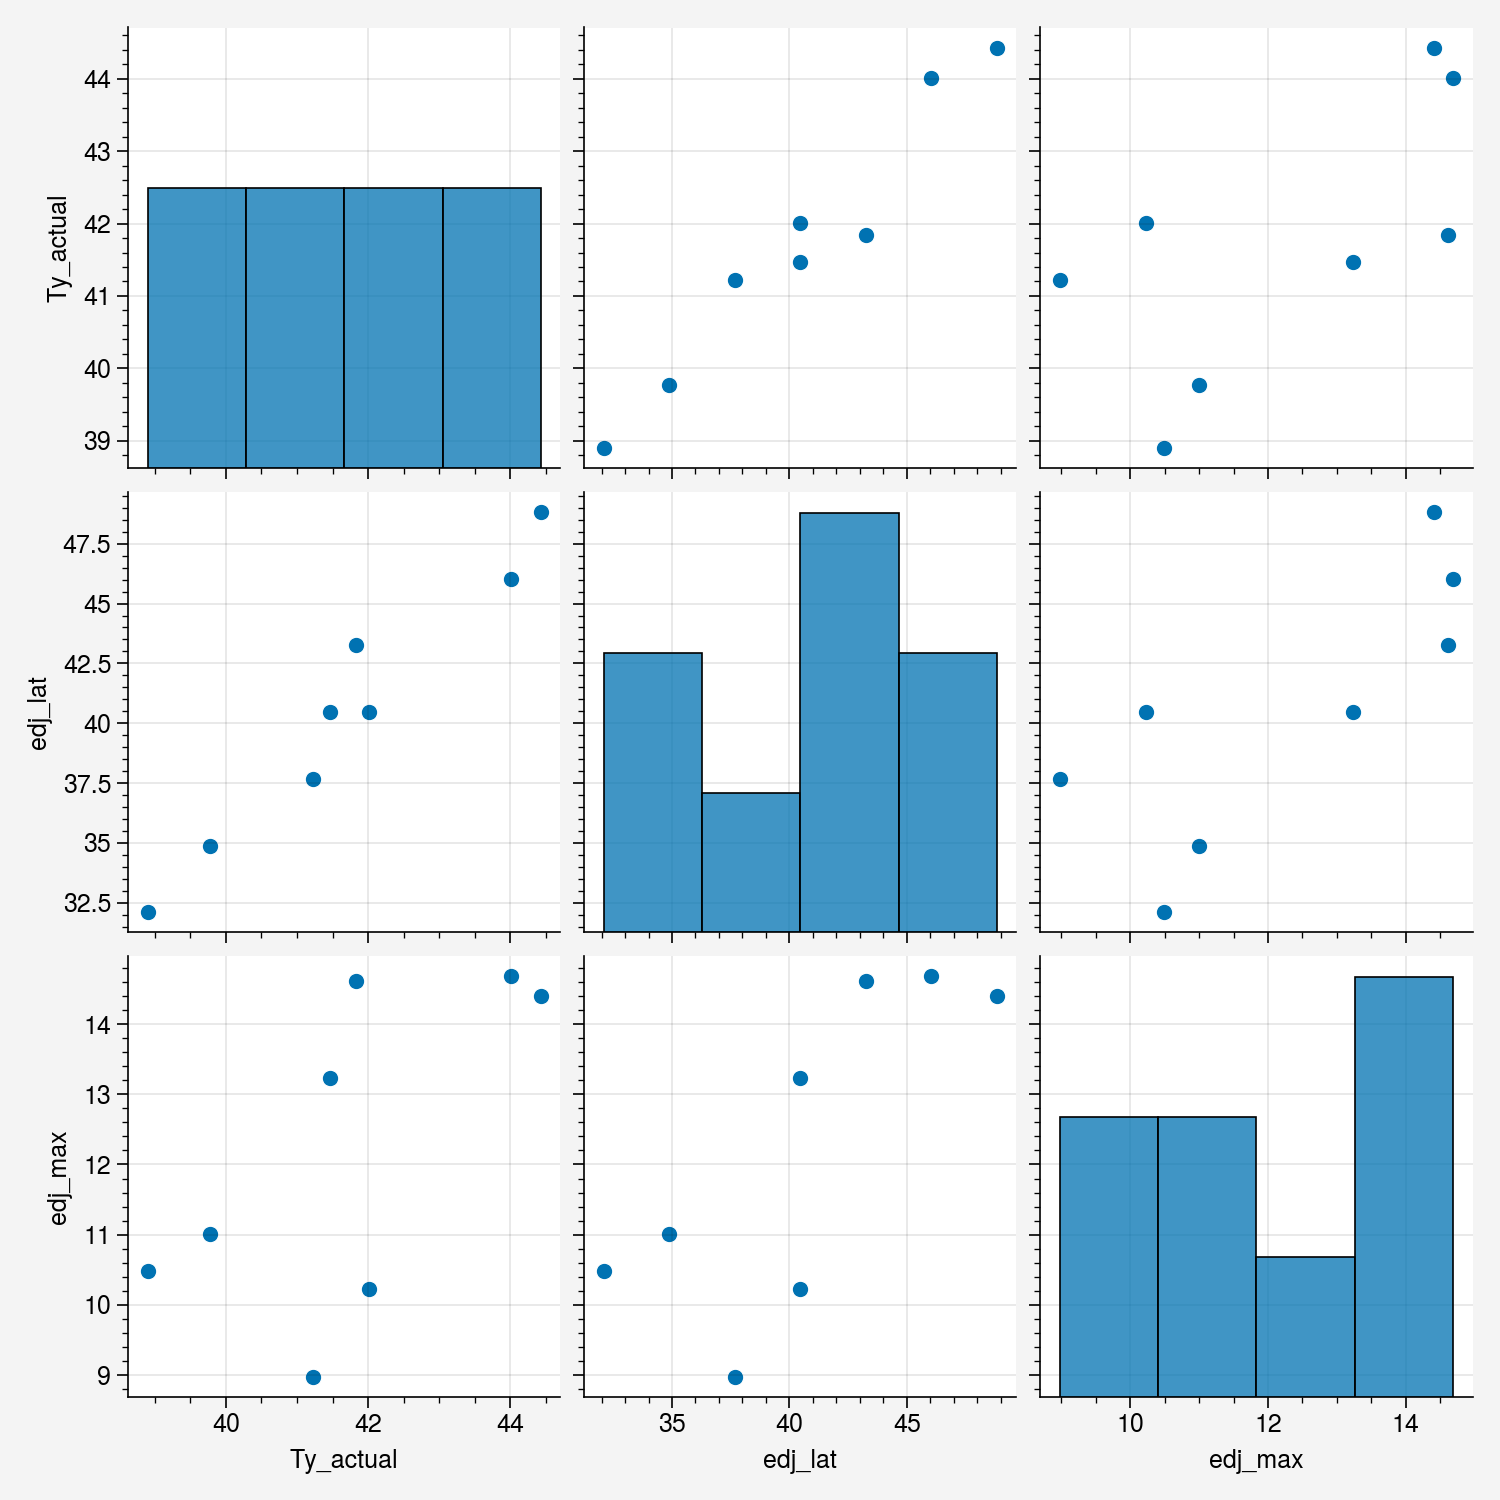

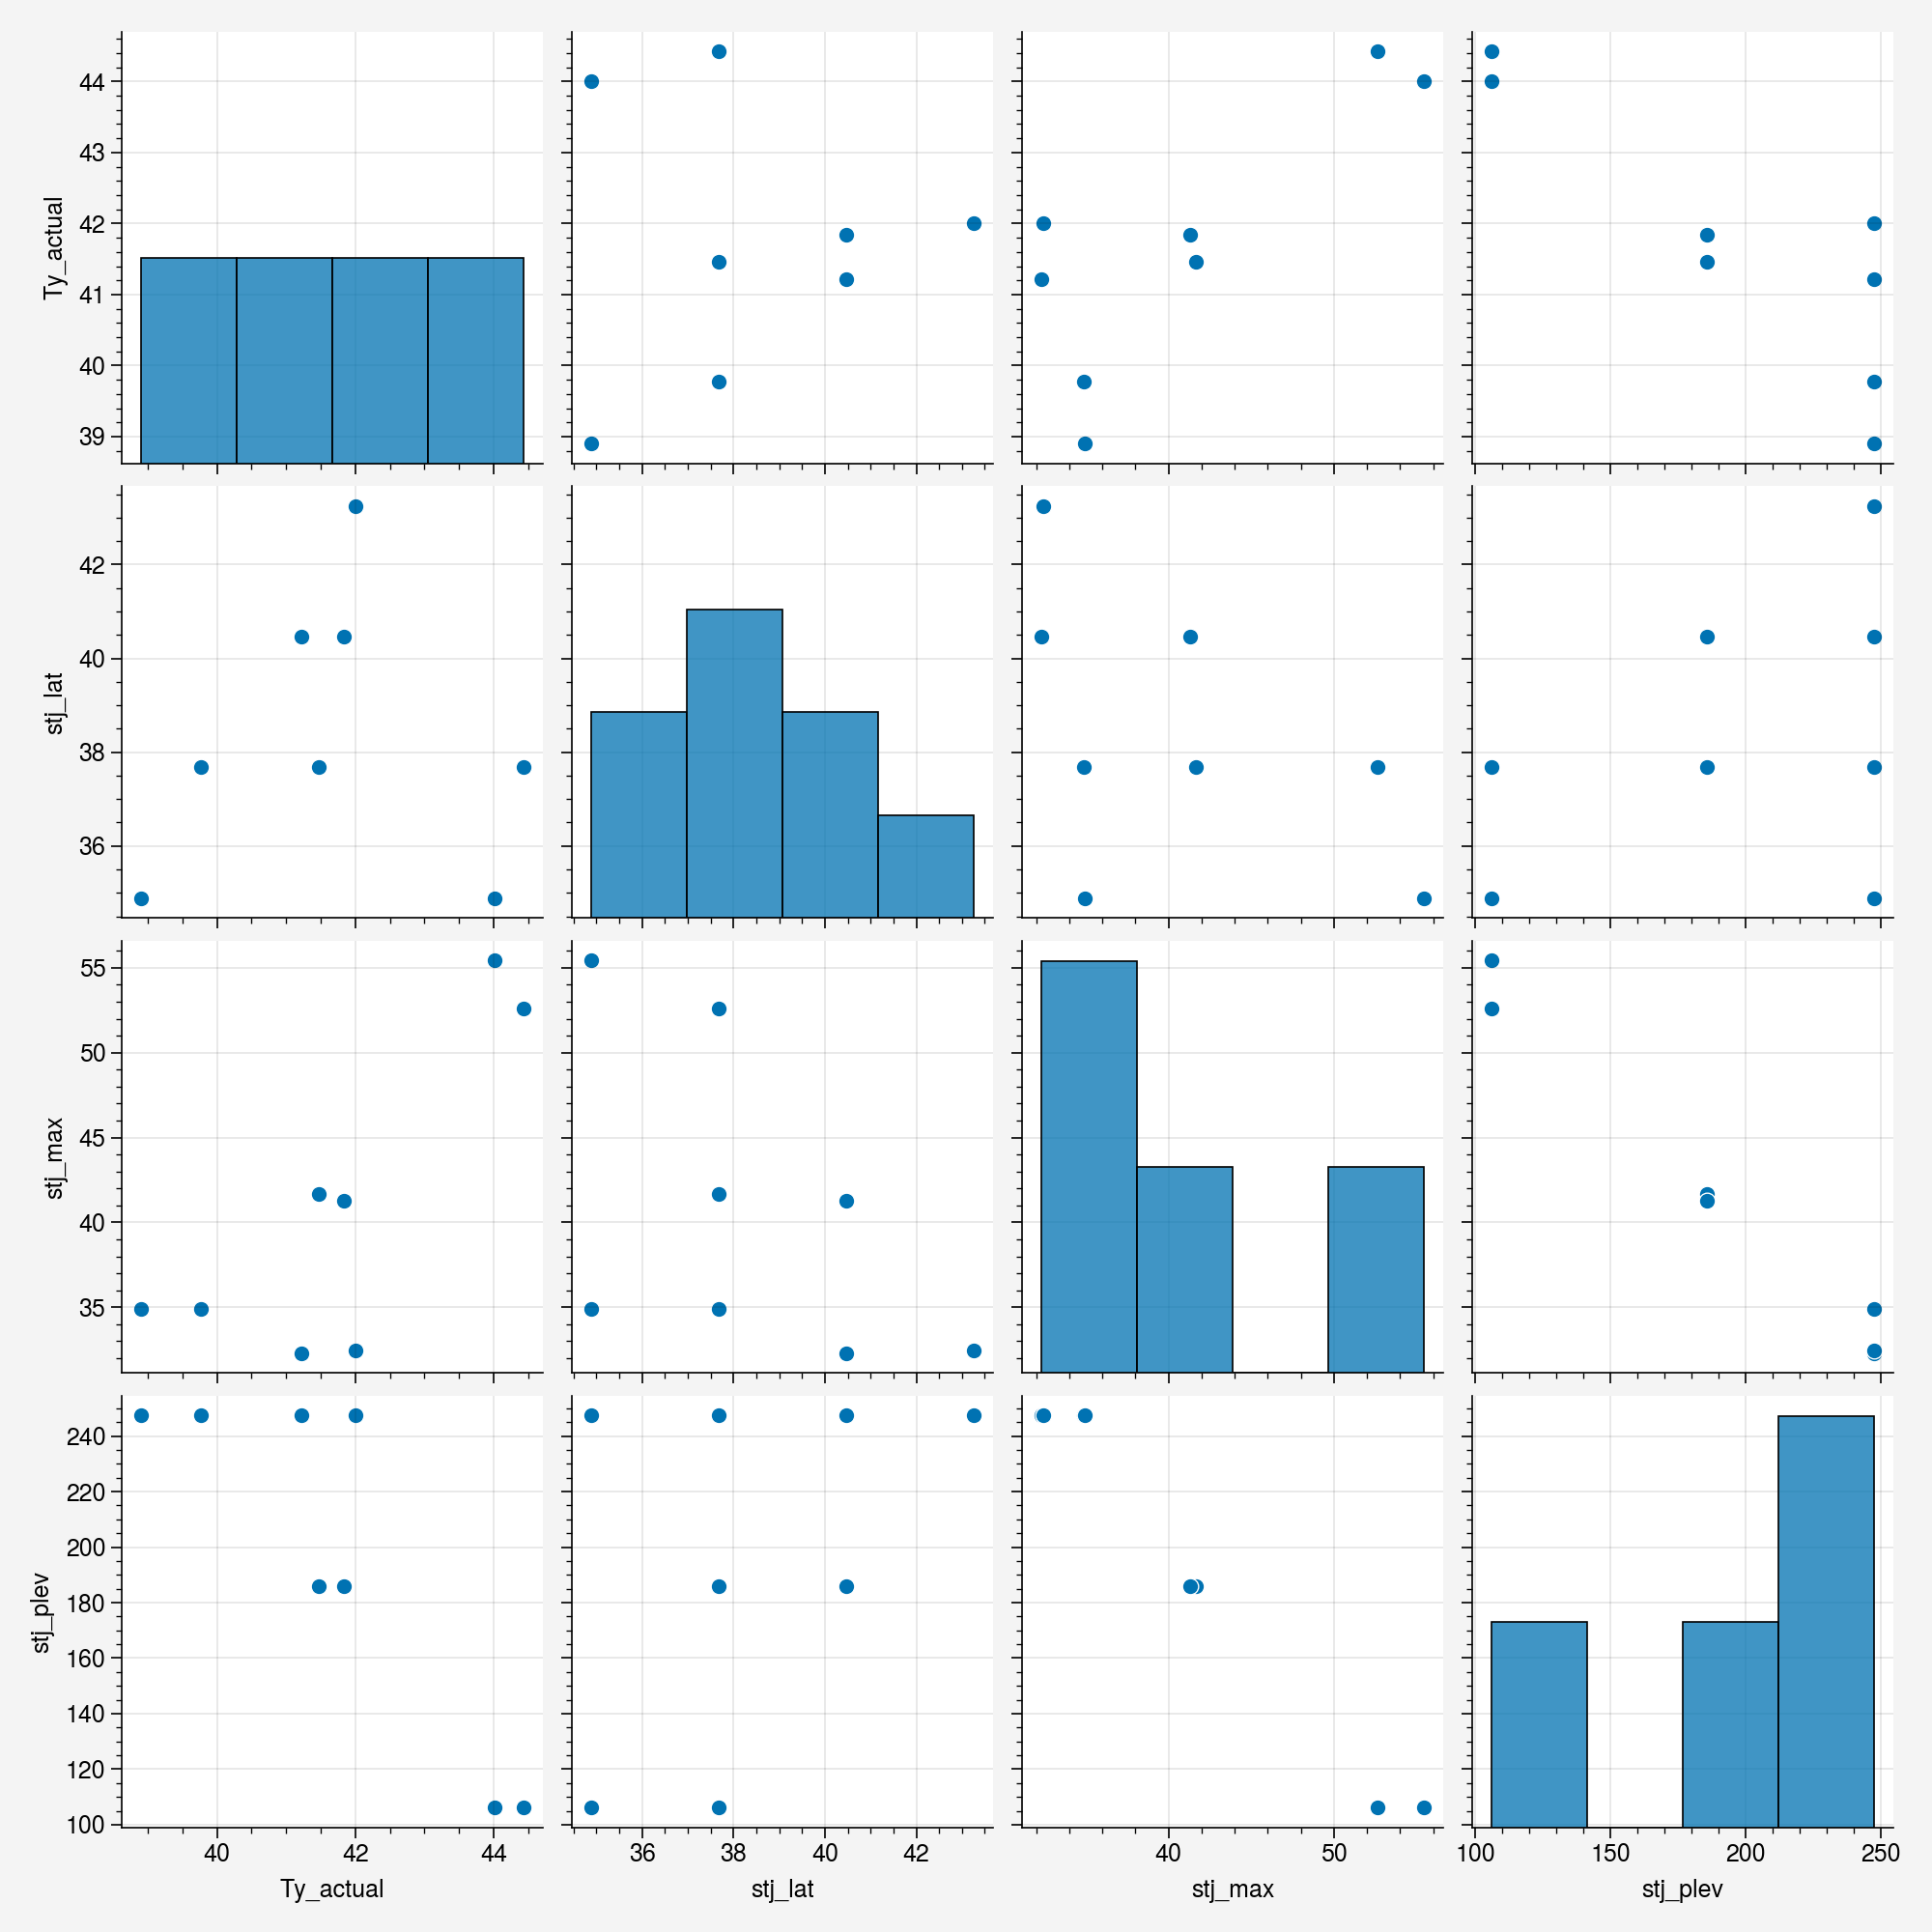

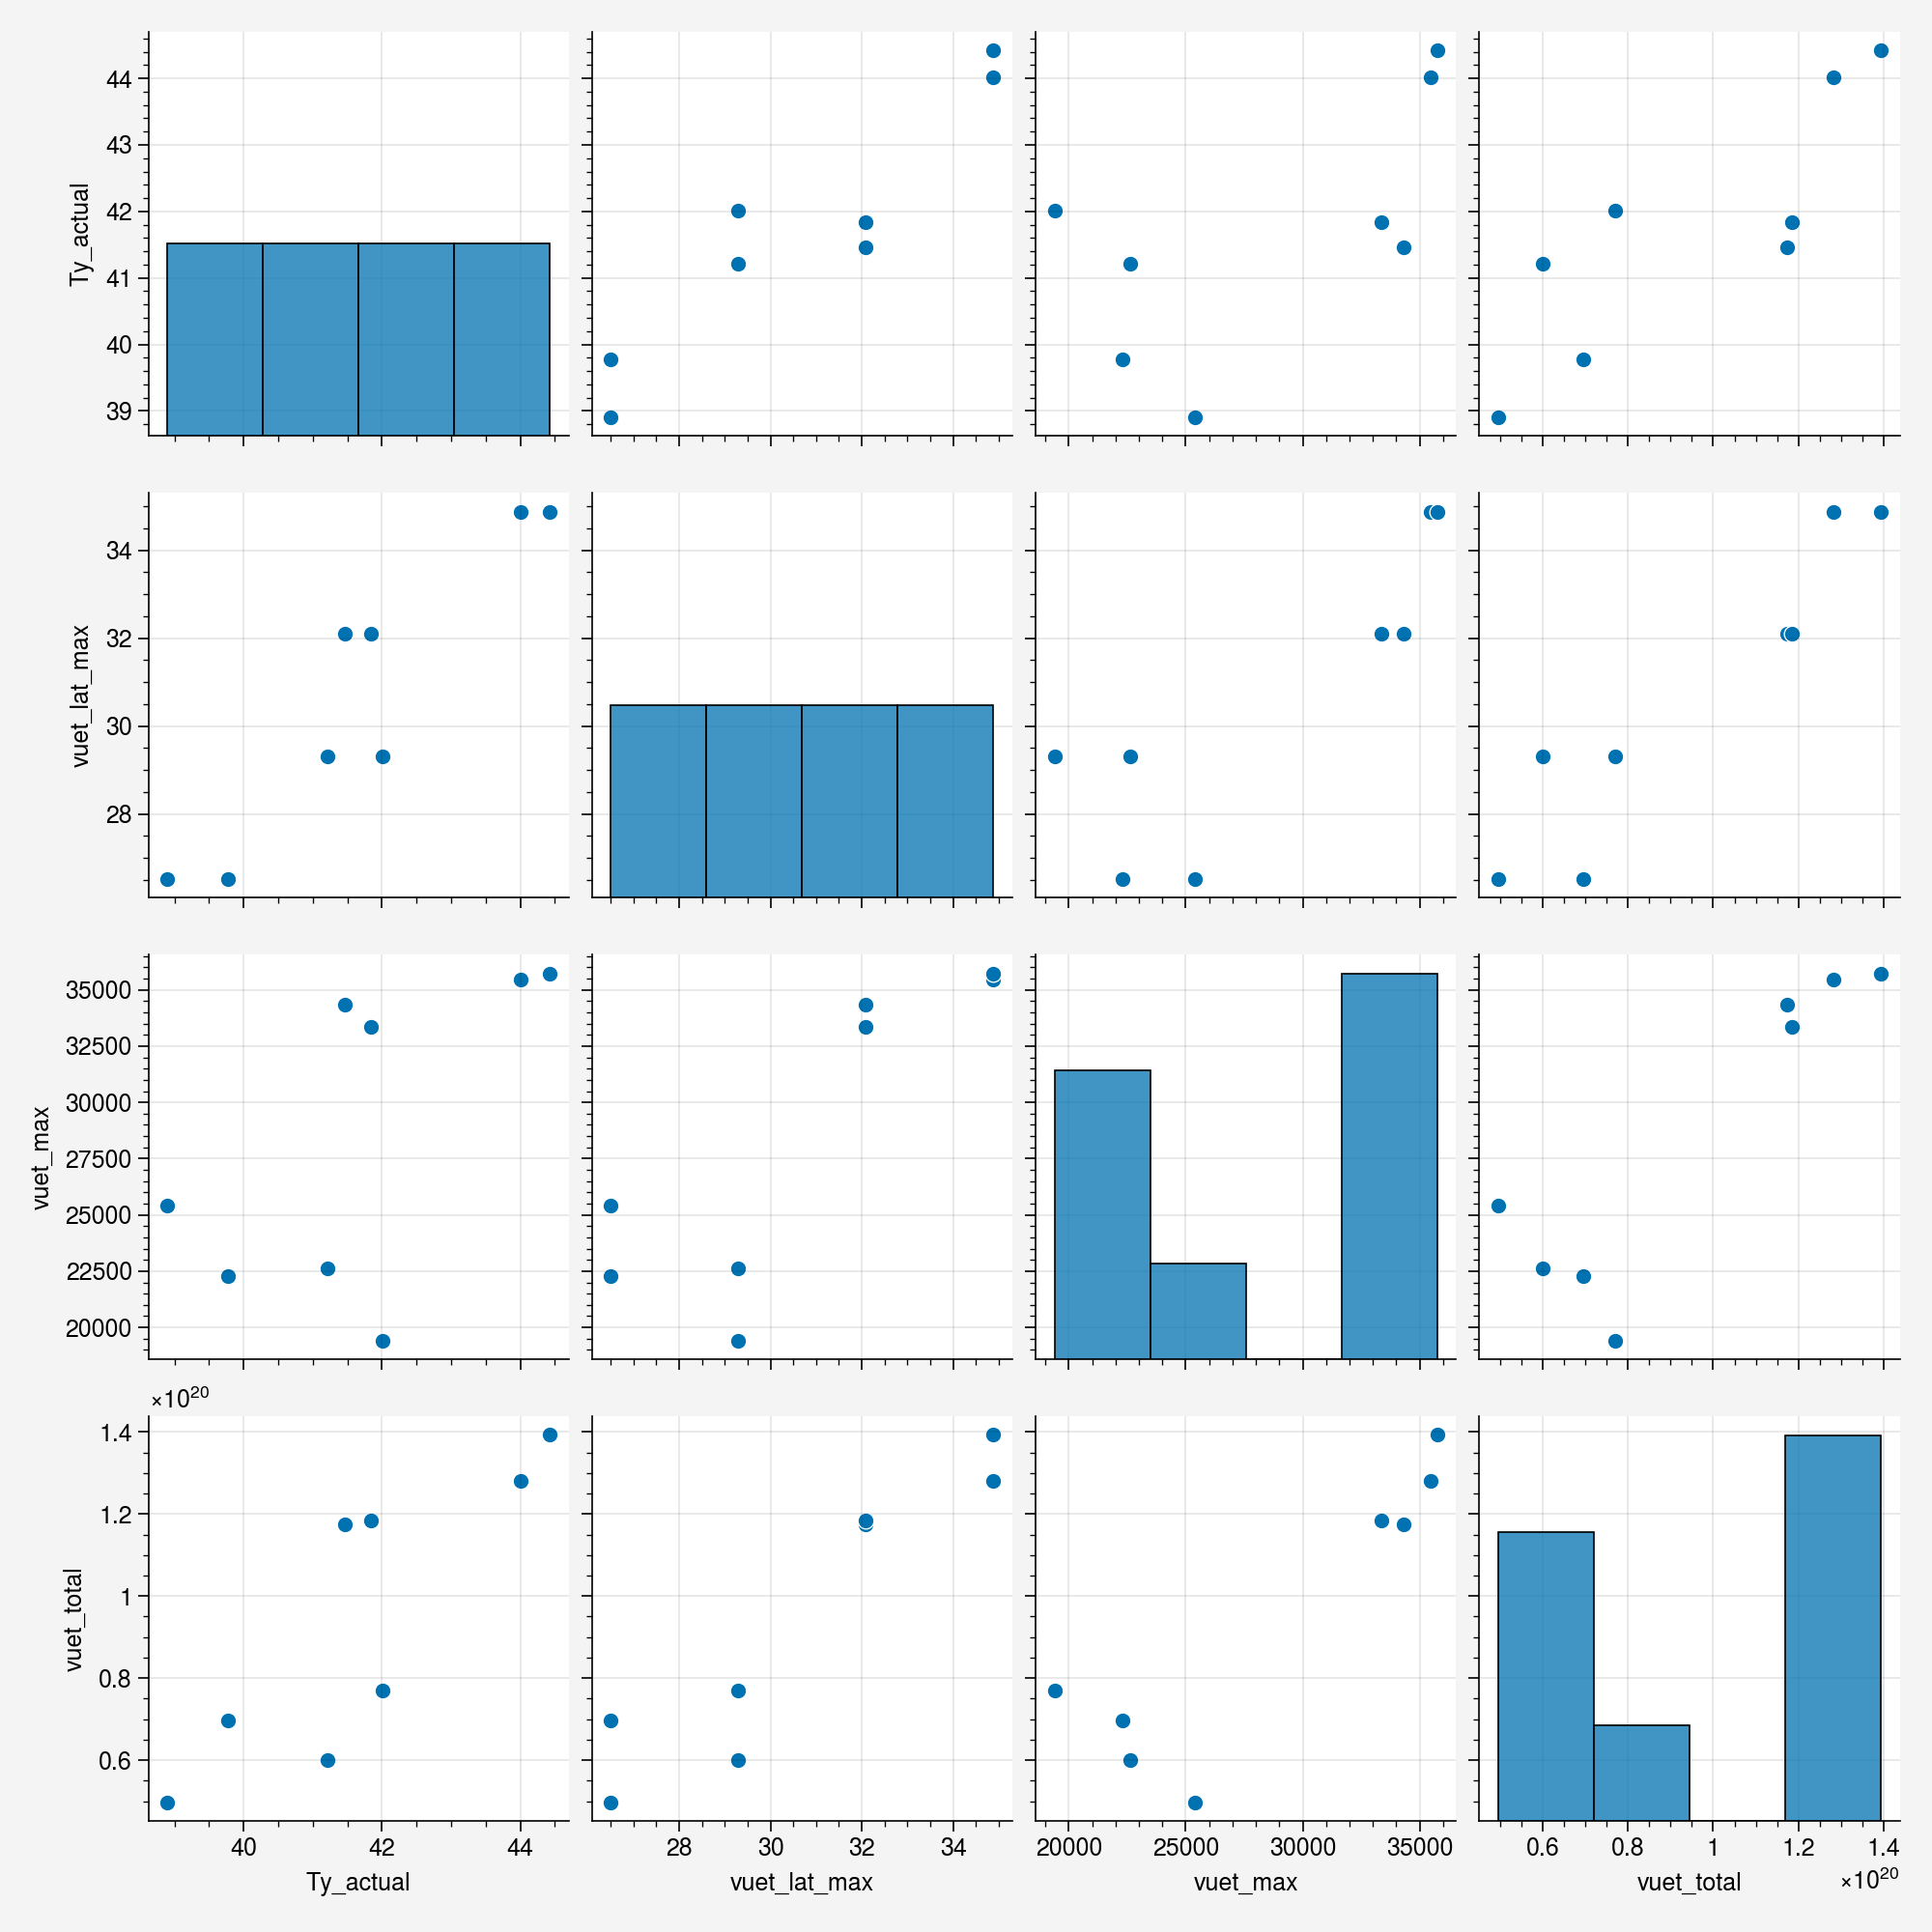

In [5]:
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe().reset_index(), vars=['Ty_actual', 'edj_lat', 'edj_max'], hue='hemisphere', diag_kind='hist')
sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe(), vars=['Ty_actual', 'edj_lat', 'edj_max'])
sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe(), vars=['Ty_actual', 'stj_lat', 'stj_max', 'stj_plev'])
sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe(), vars=['Ty_actual', 'vuet_lat_max', 'vuet_max', 'vuet_total'])

In [6]:
plt.show()

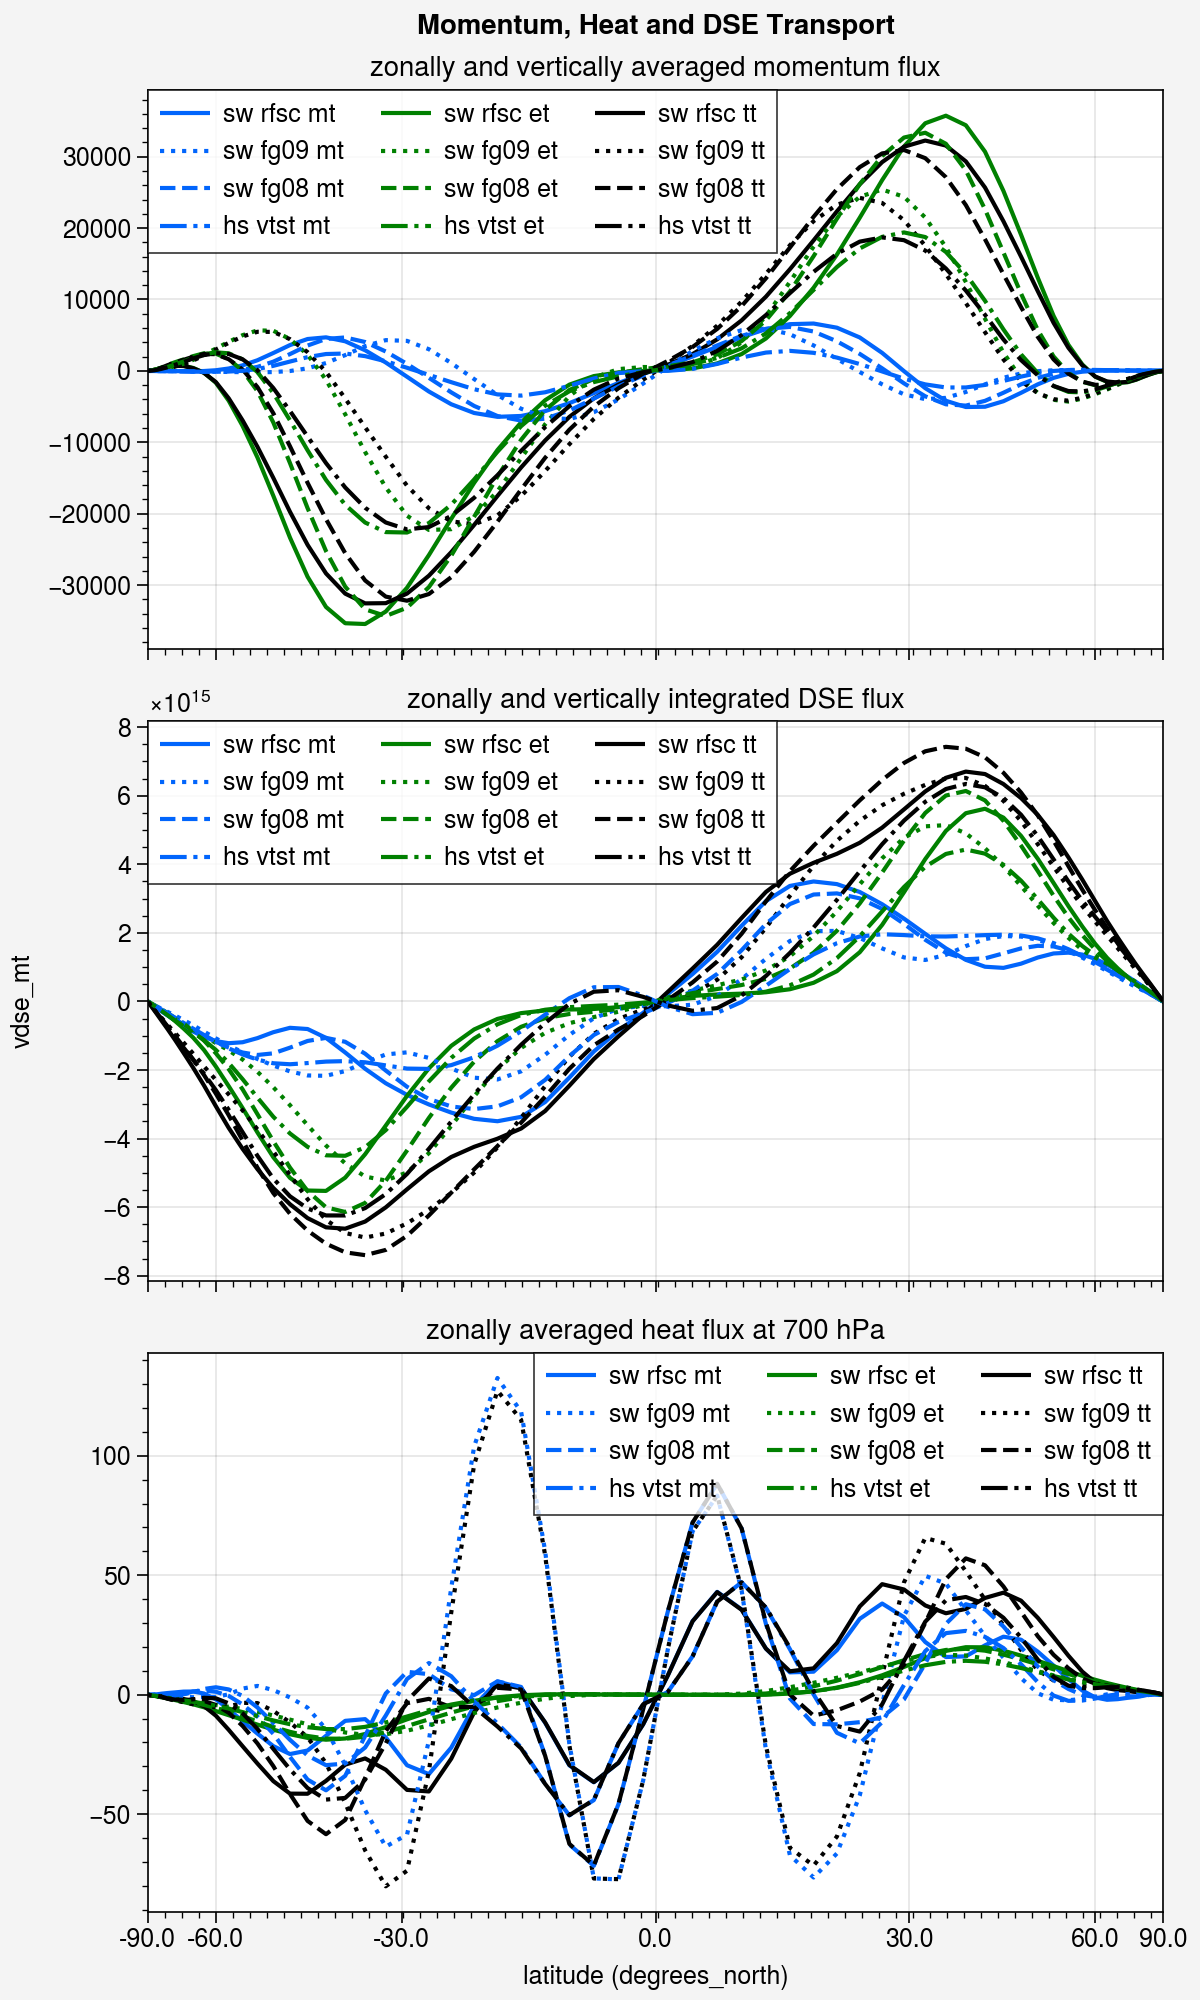

In [7]:
fig, ax = pplt.subplots(nrows = 3, ncols = 1, figsize = (6, 10), figtitle='Momentum, Heat and DSE Transport')

linestyles = ['-', ':', '--', '-.', 'dashdotdotted']

for i,en in enumerate(exp_names):
    fig, ax = plot_transports_intercomp(ds_tp.sel(exp_name=en), weights_da, 
                                        fig=fig, ax=ax, linestyle=linestyles[i],
                                       )
fig.show()
fig.savefig(f'Intercomparison_fluxes.{plot_format}')

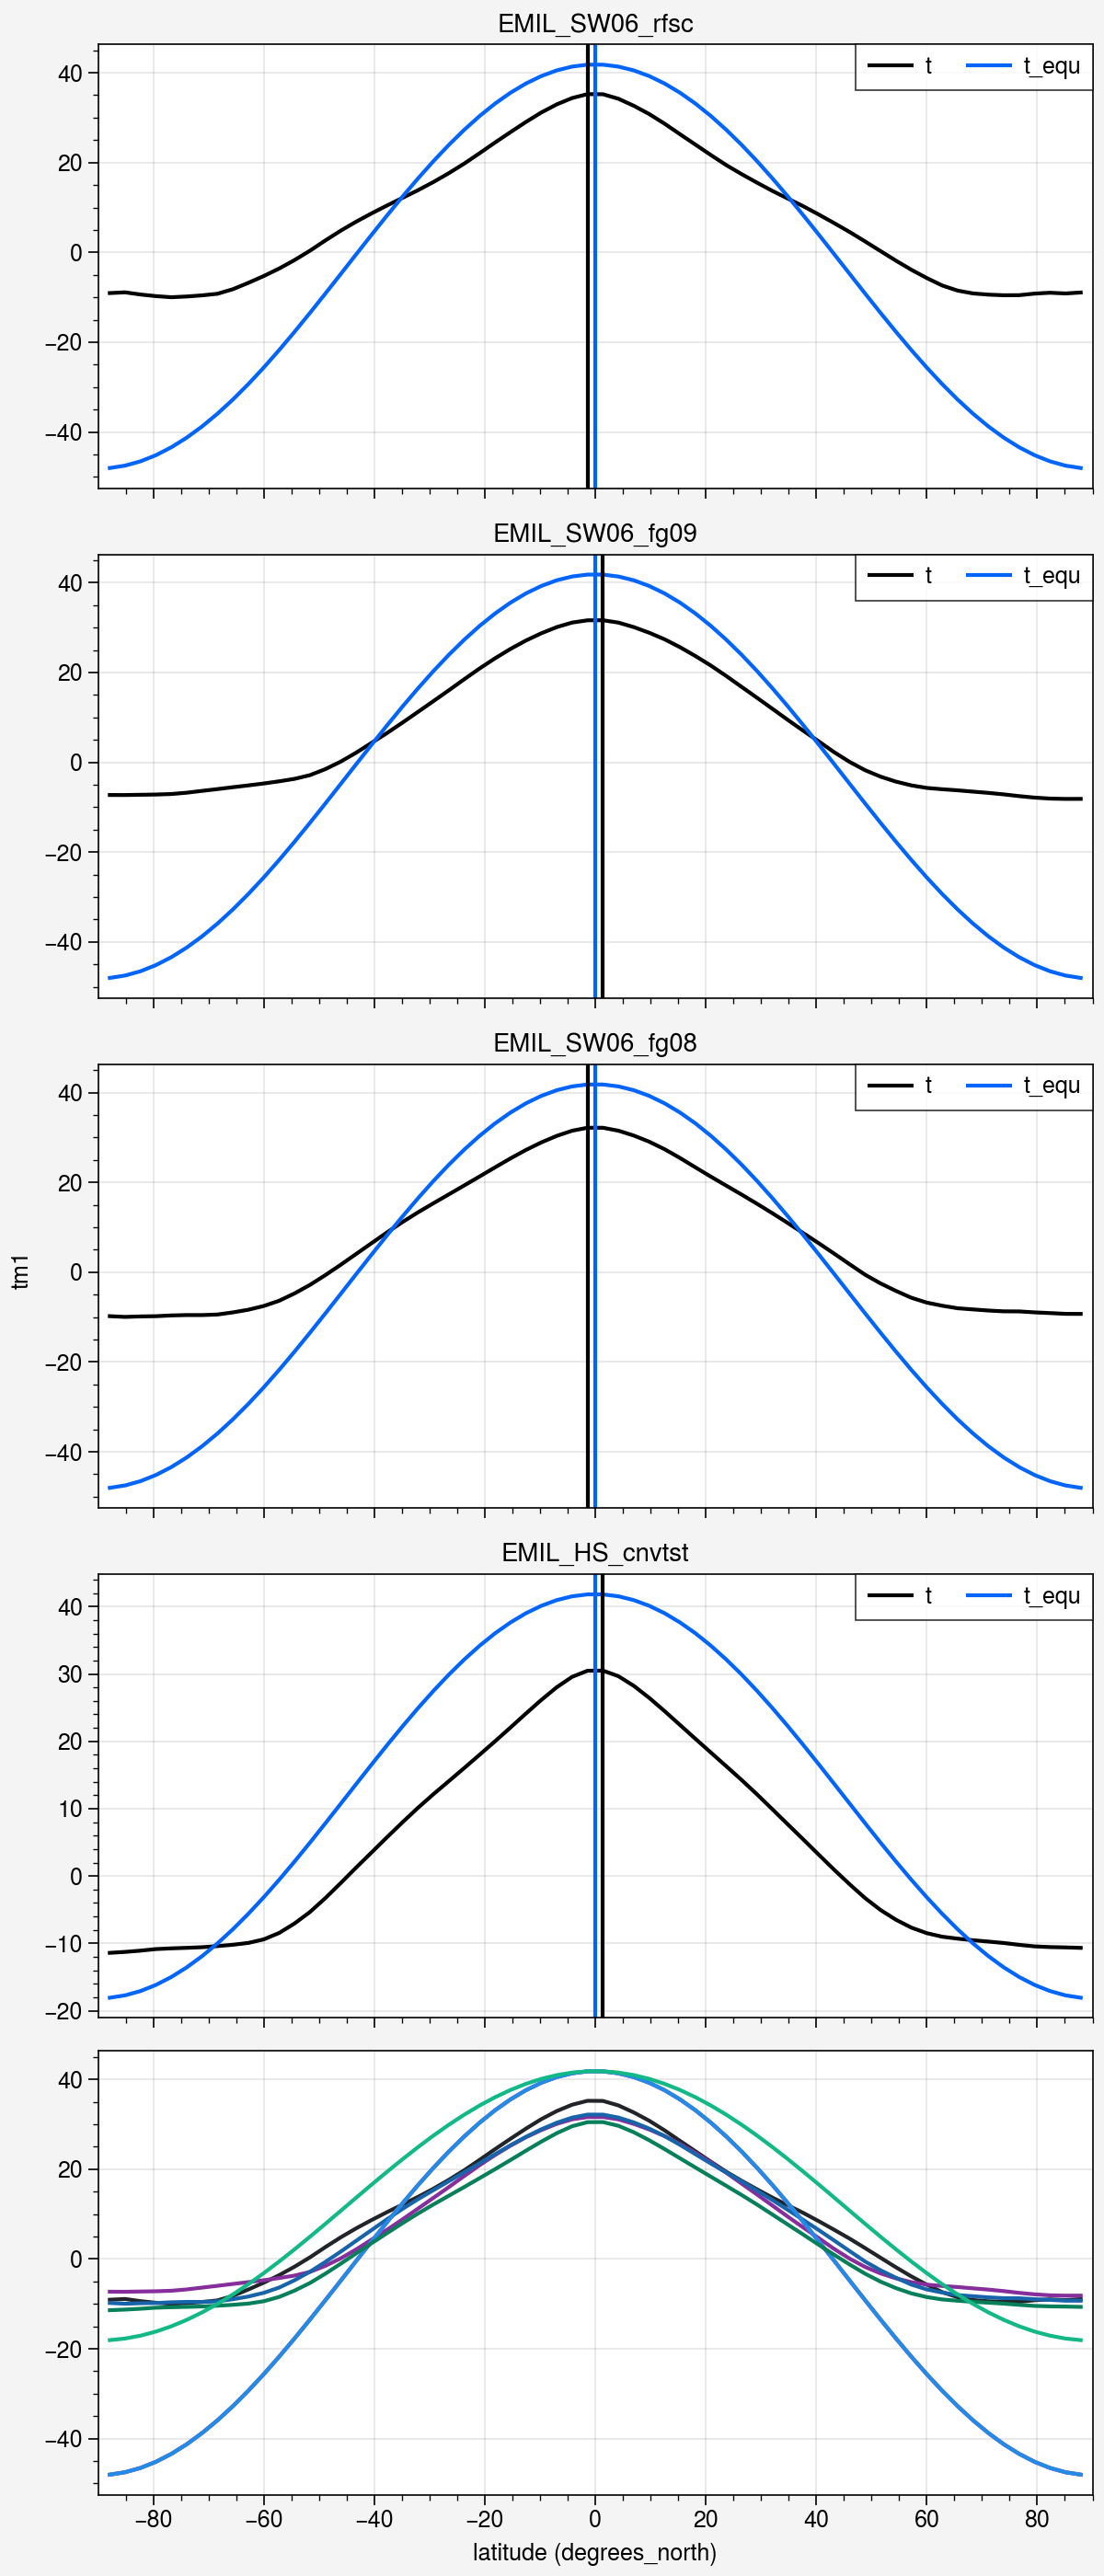

In [8]:
colors=['gray9', 'grape9', 'blue9', 'teal9', 'pink9']
colors_eq=['gray6', 'grape6', 'blue6', 'teal6', 'pink6']

fig, ax = pplt.subplots(figsize=(6,14), nrows=len(exp_names)+1, share=True)

for i, exp_name in enumerate(exp_names):
    ds = ds_zm.sel(exp_name=exp_name)
    ty = get_ty_from(exp_name)
    setup = get_setup_from(exp_name)
    l0 = get_l0_from(exp_name)

    eps= - 12.54
    da_sfct = ds.tm1.mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    l0_act = da_sfct.lat.where(da_sfct == da_sfct.max(), drop=True).values
    
    t_equ_sfc = calc_Ty_eff(setup, ty, l0, ds.lat)[2]
    t_act_sfc = ds.tm1.mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}) - 273.15
    

    ax[-1].plot(ds.lat, t_act_sfc, color=colors[i])
    ax[-1].plot(ds.lat, t_equ_sfc, color=colors_eq[i])
    #ax[-1].axvline(l0, color=colors_eq[i])
    #ax[-1].axvline(l0_act, color=colors[i])

    ax[i].plot(ds.lat, t_act_sfc, color='black', label='t')
    ax[i].plot(ds.lat, t_equ_sfc, color='bright blue', label='t_equ')
    ax[i].axvline(l0, color='bright blue')
    ax[i].axvline(l0_act, color='black')
    ax[i].set_title(exp_name)

for a in ax[:-1]:
    a.set_xlim([-90,90])
    a.legend()

(-90.0, 90.0)

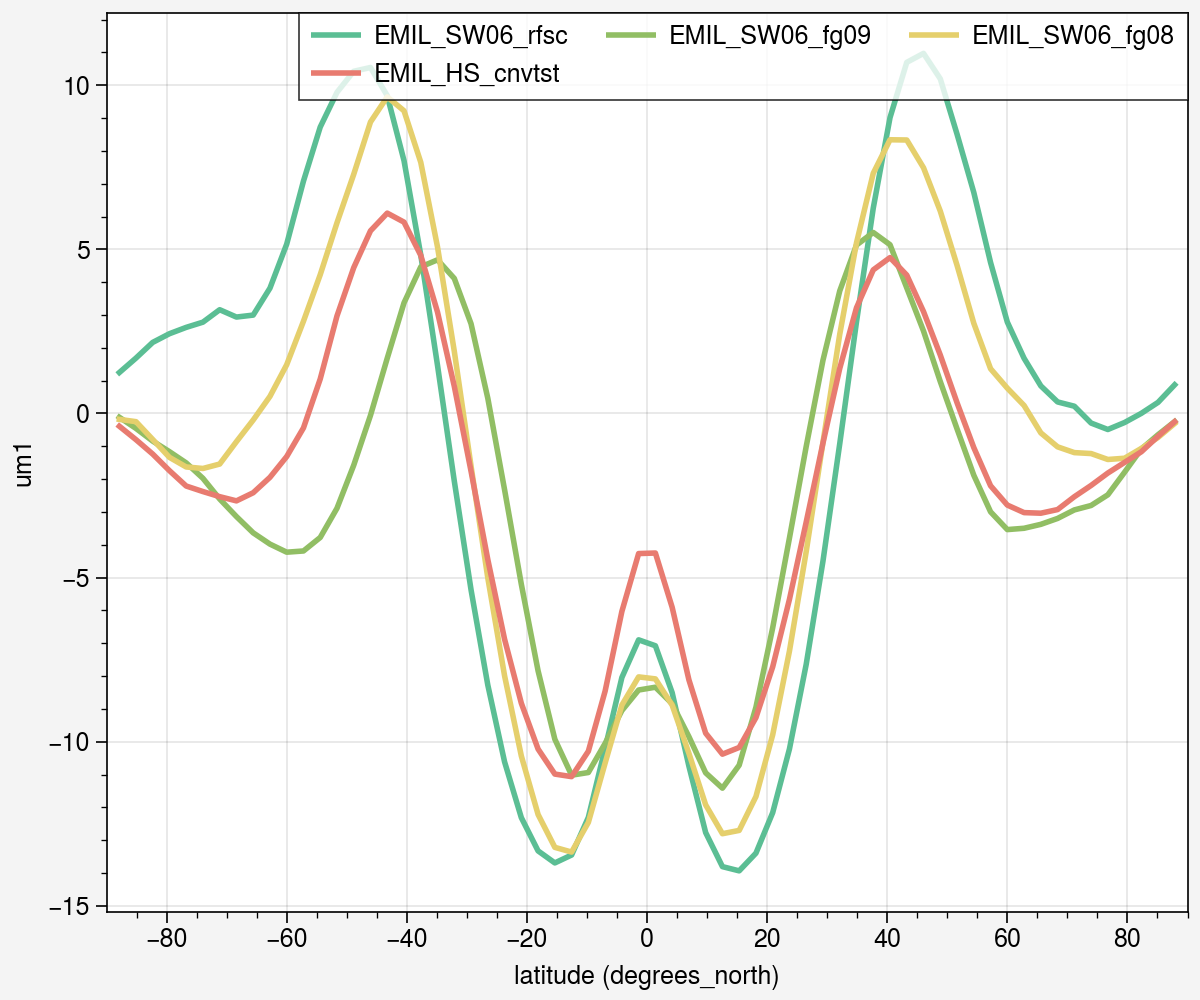

In [110]:
fig, ax = pplt.subplots(figsize=(6,5))

ax.plot(ds_zm.lat, 
    (ds_zm.um1.mean(['time']).dropna('plev')
     .interp(plev=ds_zm.plev[-1], kwargs={"fill_value": "extrapolate"}).T ),
    cycle='qual1', lw=2
)
ax.legend()

ax.set_xlim([-90,90])

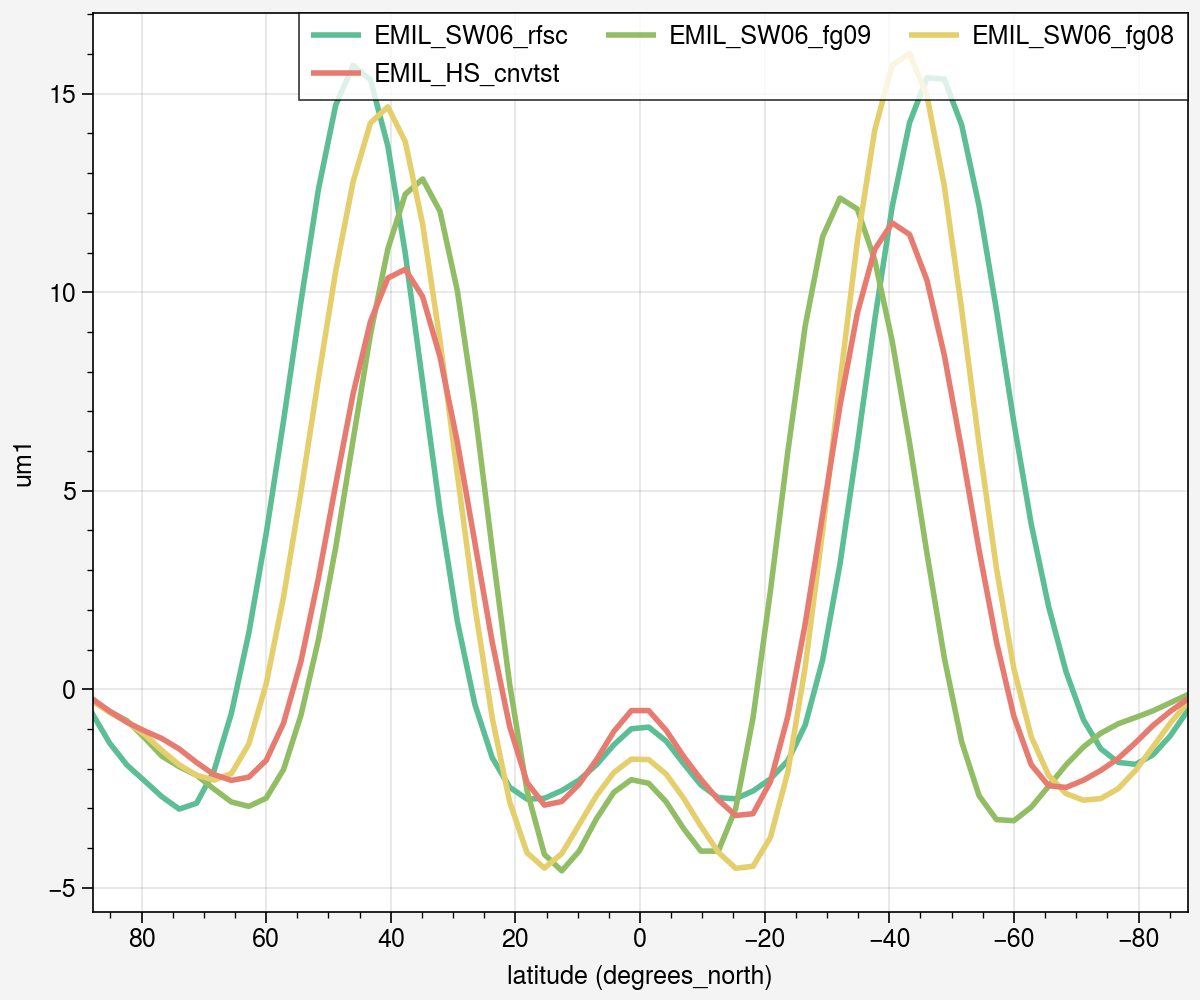

In [111]:
fig, ax = pplt.subplots(figsize=(6,5))

ax.plot(ds_zm.lat, 
    (ds_zm.um1.sel(plev=slice(700,950)).weighted(weights_da).mean(['time', 'plev'])
     .T ),
    cycle='qual1', lw=2
)
ax.legend()

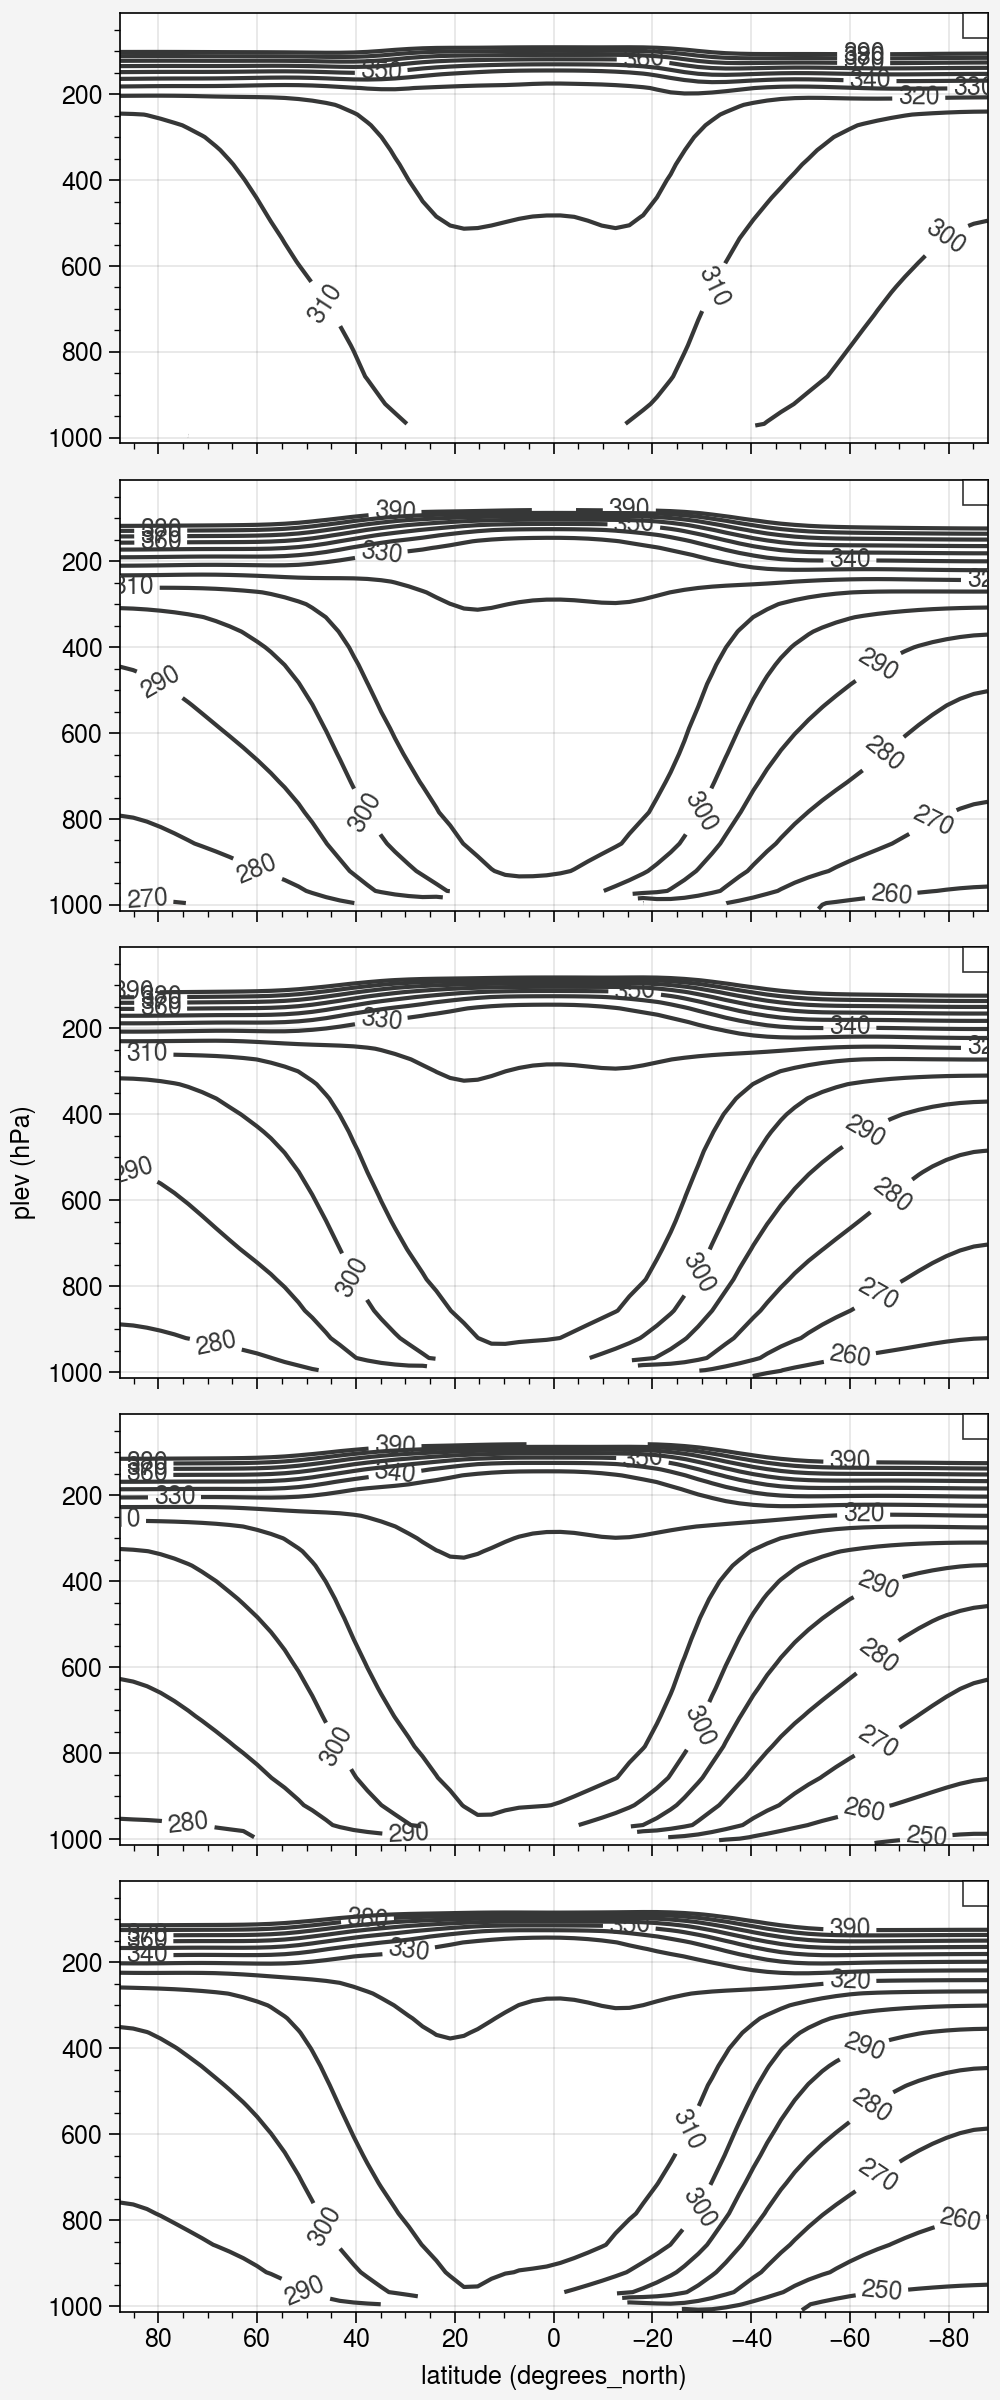

In [10]:
fig, ax = pplt.subplots(figsize=(5,12), nrows=len(exp_names))

for i,exp_name in enumerate(exp_names):
    
    ds = ds_zm.sel(exp_name=exp_name, plev=slice(80, 1013)).mean('time')
    ty = get_ty_from(exp_name)
    levels=np.arange(220, 390.1, 10)
    
    ax[i].contour(ds.lat, ds.plev, ds.theta, 
               color='dark gray', #alpha = 0.5 + 0.5*ty/100,
               levels=levels, labels=True, label=exp_name[-4:])

for a in ax:
    a.set_ylim(ylims)
    a.legend()

In [50]:
cols = list(df_diagn)
cols.sort()
df_diagn = df_diagn[cols]
df_diagn

Ty_actual      Ty_eff  Ty_equ    edj_lat  \
exp_name       hemisphere                                             
EMIL_HSl6_dy_C NH          26.643089   80.417981   100.0  46.044727   
               SH          62.219963  122.296019   100.0 -37.673088   
EMIL_HSl6_dy80 NH          29.382920   64.334386    80.0  46.044727   
               SH          56.475616   97.836810    80.0 -32.091946   
EMIL_HSl6_dy60 NH          31.414504   48.250796    60.0  43.254196   
               SH          51.642426   73.377612    60.0 -34.882523   
EMIL_HSl6_dy40 NH          34.454428   32.167192    40.0  43.254196   
               SH          47.791446   48.918405    40.0 -34.882523   
EMIL_HSl6_dy20 NH          15.058247   16.083601    20.0  34.882523   
               SH          22.363159   24.459203    20.0 -29.301359   
EMIL_SW06_dy80 NH          39.593296   68.167168    80.0  46.044727   
               SH          39.972431   93.287142    80.0 -46.044727   
EMIL_SW06_dy60 NH          32.538687   48.253828    60.0  40.463650   
               SH          32.587263   73.373803    60.0 -43.254196   
EMIL_SW06_rfsc NH          44.009062   72.376192    90.0  46.044727   
               SH          44.429610  110.066410    90.0 -48.835239   
EMIL_SW06_fg09 NH          39.772343   72.376192    90.0  34.882523   
               SH          38.899725  110.066410    90.0 -32.091946   
EMIL_SW06_fg08 NH          41.467120   72.376192    90.0  40.463650   
               SH          41.836181  110.066410    90.0 -43.254196   
EMIL_HS_cnvtst NH          41.220141   60.155122    60.0  37.673088   
               SH          42.008478   60.155122    60.0 -40.463650   

                             edj_max     lat_0  lat_0_actual    stj_lat  \
exp_name       hemisphere                                                 
EMIL_HSl6_dy_C NH           7.415107  6.000000     18.138971  48.835239   
               SH          11.654893  6.000000     18.138971 -40.463650   
EMIL_HSl6_dy80 NH           8.130749  6.000000     15.348365  46.044727   
               SH           9.363579  6.000000     15.348365 -34.882523   
EMIL_HSl6_dy60 NH           8.206985  6.000000     12.557756  43.254196   
               SH           9.615487  6.000000     12.557756 -37.673088   
EMIL_HSl6_dy40 NH           9.193595  6.000000      6.976533  43.254196   
               SH           9.283907  6.000000      6.976533 -37.673088   
EMIL_HSl6_dy20 NH           3.284964  6.000000      9.767145   1.395307   
               SH           4.412858  6.000000      9.767145  -1.395307   
EMIL_SW06_dy80 NH          12.584167  4.495167      1.395307  34.882523   
               SH          12.826592  4.495167      1.395307 -34.882523   
EMIL_SW06_dy60 NH           8.388756  5.998360      1.395307  29.301359   
               SH           8.165844  5.998360      1.395307 -29.301359   
EMIL_SW06_rfsc NH          14.683888  6.000000     -1.395307  34.882523   
               SH          14.403508  6.000000     -1.395307 -37.673088   
EMIL_SW06_fg09 NH          11.004682  6.000000      1.395307  37.673088   
               SH          10.486868  6.000000      1.395307 -34.882523   
EMIL_SW06_fg08 NH          13.235361  6.000000     -1.395307  37.673088   
               SH          14.612542  6.000000     -1.395307 -40.463650   
EMIL_HS_cnvtst NH           8.976563  0.000000      1.395307  40.463650   
               SH          10.231722  0.000000      1.395307 -43.254196   

                             stj_max    stj_plev  vuet_lat_max      vuet_max  \
exp_name       hemisphere                                                      
EMIL_HSl6_dy_C NH          22.353449  247.547394     34.882523     23.993060   
               SH          41.698574  247.547394    -29.301359     11.769304   
EMIL_HSl6_dy80 NH          23.940371  272.512787     34.882523     15.973367   
               SH          40.032551  272.512787    -23.720175     13.517318   
EMIL_HSl6_dy60 NH          26.288212  247

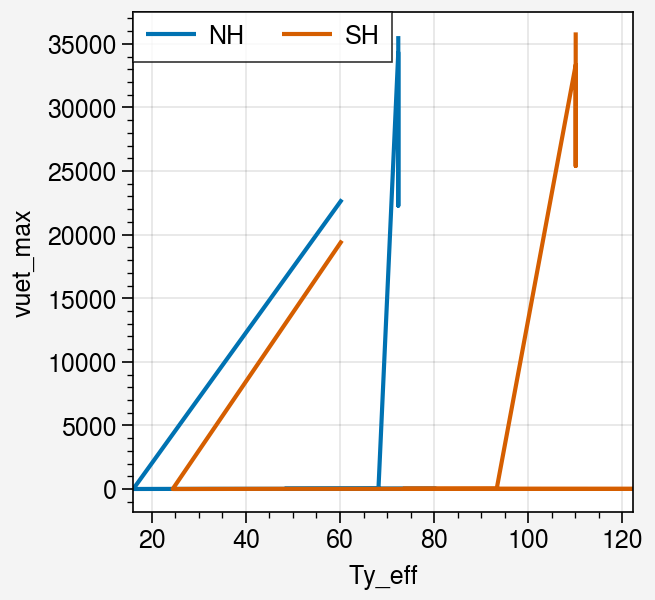

In [ ]:
ds_diagn = xr.Dataset.from_dataframe(df_diagn)
fig, ax = pplt.subplots()
ax.plot(ds_diagn.Ty_eff, ds_diagn.vuet_max)
ax.legend()

## Calculation of Diagnostics

### EDJ and STJ related

In [113]:
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name)

    edj_lat, stj_lat, edj_plev, stj_plev = calc_jet_lats(ds)
    
    df_diagn.loc[(exp_name,),'edj_lat'] = np.abs(edj_lat)
    df_diagn.loc[(exp_name,),'stj_lat'] = np.abs(stj_lat)

    df_diagn.loc[(exp_name,'NH'),'stj_max'] = ds.um1.sel(plev=stj_plev).mean(['time']).interp(lat=stj_lat[0])
    df_diagn.loc[(exp_name,'SH'),'stj_max'] = ds.um1.sel(plev=stj_plev).mean(['time']).interp(lat=stj_lat[1])
    df_diagn.loc[(exp_name,'NH'),'edj_max'] = ds.um1.sel(plev=edj_plev, method='nearest').mean(['time']).interp(lat=edj_lat[0])
    df_diagn.loc[(exp_name,'SH'),'edj_max'] = ds.um1.sel(plev=edj_plev, method='nearest').mean(['time']).interp(lat=edj_lat[1])
    df_diagn.loc[(exp_name,),'stj_plev'] = stj_plev[0]

/tmp/ipykernel_545517/2041780996.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'edj_lat'] = np.abs(edj_lat)
/tmp/ipykernel_545517/2041780996.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'stj_lat'] = np.abs(stj_lat)
/tmp/ipykernel_545517/2041780996.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'stj_plev'] = stj_plev[0]
/tmp/ipykernel_545517/2041780996.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'edj_lat'] = np.abs(edj_lat)
/tmp/ipykernel_545517/2041780996.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'stj_lat'] = np.abs(stj_lat)
/tmp/ipykernel_545517/2041780996.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'stj_plev'] = stj_plev[0]
/t

### Meridional temperature gradients

In [70]:
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name)
    ty = get_ty_from(exp_name)
    setup = get_setup_from(exp_name)
    l0 = get_l0_from(exp_name)

    da_sfct = ds.tm1.mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    l0_act = da_sfct.lat.where(da_sfct == da_sfct.max(), drop=True).values
    
    ## Calculation of hemispheric temperature difference on NH
    df_diagn.loc[(exp_name,'NH'),'Ty_actual'] = (
        ds.tm1.mean('time').dropna('plev').interp(lat=l0_act, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}) - 
        ds.tm1.mean('time').dropna('plev').interp(lat=90, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    )

    ## Calculation of hemispheric temperature difference on SH
    df_diagn.loc[(exp_name,'SH'),'Ty_actual'] = (
        ds.tm1.mean('time').dropna('plev').interp(lat=l0_act, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}) - 
        ds.tm1.mean('time').dropna('plev').interp(lat=-90, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    )

    ## Calculation of hemispheric temperature difference from T_equ
    df_diagn.loc[(exp_name,),'Ty_eff'] = calc_Ty_eff(setup, ty, l0, ds.lat)[:2]
    t_equ_sfc = calc_Ty_eff(setup, ty, l0, ds.lat)[2]
    
    ## Calculation of the latitudes of the surface temperature maxima in T_equ and the actual T_sfc  
    df_diagn.loc[(exp_name,),'lat_0'] = l0
    df_diagn.loc[(exp_name,),'lat_0_actual'] = float(l0_act)

    ## Saving the nominal temperature difference 
    df_diagn.loc[(exp_name,),'Ty_equ'] = ty

df_diagn

/tmp/ipykernel_545517/1715102538.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'Ty_eff'] = calc_Ty_eff(setup, ty, l0, ds.lat)[:2]
/tmp/ipykernel_545517/1715102538.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'lat_0'] = l0
/tmp/ipykernel_545517/1715102538.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'lat_0_actual'] = float(l0_act)
/tmp/ipykernel_545517/1715102538.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'Ty_equ'] = ty
/tmp/ipykernel_545517/1715102538.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'Ty_eff'] = calc_Ty_eff(setup, ty, l0, ds.lat)[:2]
/tmp/ipykernel_545517/1715102538.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'la

Ty_actual      Ty_eff  Ty_equ    edj_lat  \
exp_name       hemisphere                                             
EMIL_HSl6_dy_C NH          26.643089   80.417981   100.0  46.044727   
               SH          62.219963  122.296019   100.0 -37.673088   
EMIL_HSl6_dy80 NH          29.382920   64.334386    80.0  46.044727   
               SH          56.475616   97.836810    80.0 -32.091946   
EMIL_HSl6_dy60 NH          31.414504   48.250796    60.0  43.254196   
               SH          51.642426   73.377612    60.0 -34.882523   
EMIL_HSl6_dy40 NH          34.454428   32.167192    40.0  43.254196   
               SH          47.791446   48.918405    40.0 -34.882523   
EMIL_HSl6_dy20 NH          15.058247   16.083601    20.0  34.882523   
               SH          22.363159   24.459203    20.0 -29.301359   
EMIL_SW06_dy80 NH          39.593296   68.167168    80.0  46.044727   
               SH          39.972431   93.287142    80.0 -46.044727   
EMIL_SW06_dy60 NH          32.538687   48.253828    60.0  40.463650   
               SH          32.587263   73.373803    60.0 -43.254196   
EMIL_SW06_rfsc NH          44.009062   90.232679    90.0  46.044727   
               SH          44.429610   90.232679    90.0 -48.835239   
EMIL_SW06_fg09 NH          39.772343   90.232679    90.0  34.882523   
               SH          38.899725   90.232679    90.0 -32.091946   
EMIL_SW06_fg08 NH          41.467120   90.232679    90.0  40.463650   
               SH          41.836181   90.232679    90.0 -43.254196   
EMIL_HS_cnvtst NH          41.220141   60.155122    60.0  37.673088   
               SH          42.008478   60.155122    60.0 -40.463650   

                             edj_max     lat_0  lat_0_actual    stj_lat  \
exp_name       hemisphere                                                 
EMIL_HSl6_dy_C NH           7.415107  6.000000     18.138971  48.835239   
               SH          11.654893  6.000000     18.138971 -40.463650   
EMIL_HSl6_dy80 NH           8.130749  6.000000     15.348365  46.044727   
               SH           9.363579  6.000000     15.348365 -34.882523   
EMIL_HSl6_dy60 NH           8.206985  6.000000     12.557756  43.254196   
               SH           9.615487  6.000000     12.557756 -37.673088   
EMIL_HSl6_dy40 NH           9.193595  6.000000      6.976533  43.254196   
               SH           9.283907  6.000000      6.976533 -37.673088   
EMIL_HSl6_dy20 NH           3.284964  6.000000      9.767145   1.395307   
               SH           4.412858  6.000000      9.767145  -1.395307   
EMIL_SW06_dy80 NH          12.584167  4.495167      1.395307  34.882523   
               SH          12.826592  4.495167      1.395307 -34.882523   
EMIL_SW06_dy60 NH           8.388756  5.998360      1.395307  29.301359   
               SH           8.165844  5.998360      1.395307 -29.301359   
EMIL_SW06_rfsc NH          14.683888  0.000000     -1.395307  34.882523   
               SH          14.403508  0.000000     -1.395307 -37.673088   
EMIL_SW06_fg09 NH          11.004682  0.000000      1.395307  37.673088   
               SH          10.486868  0.000000      1.395307 -34.882523   
EMIL_SW06_fg08 NH          13.235361  0.000000     -1.395307  37.673088   
               SH          14.612542  0.000000     -1.395307 -40.463650   
EMIL_HS_cnvtst NH           8.976563  0.000000      1.395307  40.463650   
               SH          10.231722  0.000000      1.395307 -43.254196   

                             stj_max    stj_plev  vuet_lat_max      vuet_max  \
exp_name       hemisphere                                                      
EMIL_HSl6_dy_C NH          22.353449  247.547394     34.882523     23.993060   
               SH          41.698574  247.547394    -29.301359     11.769304   
EMIL_HSl6_dy80 NH          23.940371  272.512787     34.882523     15.973367   
               SH          40.032551  272.512787    -23.720175     13.517318   
EMIL_HSl6_dy60 NH          26.288212  247

### Eddy momentum transport related

In [116]:
for exp_name in exp_names:
    ds = ds_tp.vu_et.weighted(weights=weights_da).mean('plev').sel(exp_name=exp_name)
    #ds_vuet_dg_nh = max_latitude(ds.sel(lat=slice(90,0)))
    #ds_vuet_dg_sh = max_latitude(-ds.sel(lat=slice(0,-90)))
    
    vuet_max_lat_nh = calculate_max_lat(ds.sel(lat=slice(90,0)).mean('time'))
    vuet_max_lat_sh = calculate_max_lat(-ds.sel(lat=slice(0,-90)).mean('time'))
    
    #print(ds_vuet_dg_nh.mean('time'), ds_vuet_dg_sh.mean('time'))
    #print(vuet_max_lat_nh, vuet_max_lat_sh)
    
    df_diagn.loc[(exp_name,'SH'),'vuet_max'] = (ds.sel(lat=slice(90,0)).mean('time')).max('lat')
    df_diagn.loc[(exp_name,'NH'),'vuet_max'] = (-ds.sel(lat=slice(0,-90)).mean('time')).max('lat')
    
    df_diagn.loc[(exp_name,),'vuet_lat_max'] = np.abs([vuet_max_lat_nh, vuet_max_lat_sh])
    
    factor = 0.5*np.pi*r_e * 2*np.pi*r_e
    df_diagn.loc[(exp_name,'NH'),'vuet_total'] = factor * (ds.sel(lat=slice(90,0)).mean('time')).sum('lat')
    df_diagn.loc[(exp_name,'SH'),'vuet_total'] = factor * (-ds.sel(lat=slice(0,-90)).mean('time')).sum('lat')
df_diagn

/tmp/ipykernel_545517/2947697817.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'vuet_lat_max'] = np.abs([vuet_max_lat_nh, vuet_max_lat_sh])
/tmp/ipykernel_545517/2947697817.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'vuet_lat_max'] = np.abs([vuet_max_lat_nh, vuet_max_lat_sh])
/tmp/ipykernel_545517/2947697817.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'vuet_lat_max'] = np.abs([vuet_max_lat_nh, vuet_max_lat_sh])
/tmp/ipykernel_545517/2947697817.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_diagn.loc[(exp_name,),'vuet_lat_max'] = np.abs([vuet_max_lat_nh, vuet_max_lat_sh])


Ty_actual      Ty_eff  Ty_equ    edj_lat  \
exp_name       hemisphere                                             
EMIL_HSl6_dy_C NH          26.643089   80.417981   100.0  46.044727   
               SH          62.219963  122.296019   100.0 -37.673088   
EMIL_HSl6_dy80 NH          29.382920   64.334386    80.0  46.044727   
               SH          56.475616   97.836810    80.0 -32.091946   
EMIL_HSl6_dy60 NH          31.414504   48.250796    60.0  43.254196   
               SH          51.642426   73.377612    60.0 -34.882523   
EMIL_HSl6_dy40 NH          34.454428   32.167192    40.0  43.254196   
               SH          47.791446   48.918405    40.0 -34.882523   
EMIL_HSl6_dy20 NH          15.058247   16.083601    20.0  34.882523   
               SH          22.363159   24.459203    20.0 -29.301359   
EMIL_SW06_dy80 NH          39.593296   68.167168    80.0  46.044727   
               SH          39.972431   93.287142    80.0 -46.044727   
EMIL_SW06_dy60 NH          32.538687   48.253828    60.0  40.463650   
               SH          32.587263   73.373803    60.0 -43.254196   
EMIL_SW06_rfsc NH          44.009062   90.232679    90.0  46.044727   
               SH          44.429610   90.232679    90.0  48.835239   
EMIL_SW06_fg09 NH          39.772343   90.232679    90.0  34.882523   
               SH          38.899725   90.232679    90.0  32.091946   
EMIL_SW06_fg08 NH          41.467120   90.232679    90.0  40.463650   
               SH          41.836181   90.232679    90.0  43.254196   
EMIL_HS_cnvtst NH          41.220141   60.155122    60.0  37.673088   
               SH          42.008478   60.155122    60.0  40.463650   

                             edj_max     lat_0  lat_0_actual    stj_lat  \
exp_name       hemisphere                                                 
EMIL_HSl6_dy_C NH           7.415107  6.000000     18.138971  48.835239   
               SH          11.654893  6.000000     18.138971 -40.463650   
EMIL_HSl6_dy80 NH           8.130749  6.000000     15.348365  46.044727   
               SH           9.363579  6.000000     15.348365 -34.882523   
EMIL_HSl6_dy60 NH           8.206985  6.000000     12.557756  43.254196   
               SH           9.615487  6.000000     12.557756 -37.673088   
EMIL_HSl6_dy40 NH           9.193595  6.000000      6.976533  43.254196   
               SH           9.283907  6.000000      6.976533 -37.673088   
EMIL_HSl6_dy20 NH           3.284964  6.000000      9.767145   1.395307   
               SH           4.412858  6.000000      9.767145  -1.395307   
EMIL_SW06_dy80 NH          12.584167  4.495167      1.395307  34.882523   
               SH          12.826592  4.495167      1.395307 -34.882523   
EMIL_SW06_dy60 NH           8.388756  5.998360      1.395307  29.301359   
               SH           8.165844  5.998360      1.395307 -29.301359   
EMIL_SW06_rfsc NH          14.683888  0.000000     -1.395307  34.882523   
               SH          14.403508  0.000000     -1.395307  37.673088   
EMIL_SW06_fg09 NH          11.004682  0.000000      1.395307  37.673088   
               SH          10.486868  0.000000      1.395307  34.882523   
EMIL_SW06_fg08 NH          13.235361  0.000000     -1.395307  37.673088   
               SH          14.612542  0.000000     -1.395307  40.463650   
EMIL_HS_cnvtst NH           8.976563  0.000000      1.395307  40.463650   
               SH          10.231722  0.000000      1.395307  43.254196   

                             stj_max    stj_plev  vuet_lat_max      vuet_max  \
exp_name       hemisphere                                                      
EMIL_HSl6_dy_C NH          22.353449  247.547394     34.882523     23.993060   
               SH          41.698574  247.547394    -29.301359     11.769304   
EMIL_HSl6_dy80 NH          23.940371  272.512787     34.882523     15.973367   
               SH          40.032551  272.512787    -23.720175     13.517318   
EMIL_HSl6_dy60 NH          26.288212  247

In [117]:
os.chdir(csv_path)
df_diagn.to_csv('diagnostics.csv')
os.chdir(outpath)